# 量子最適化アプリケーション
Kifumi Numata, IBM Quantum (Jun 26, 2023)

## VQE (Variational Quantum Eigensolver)の例

Qiskit Algorithmsライブラリーを使って、VQEで水素分子の基底エネルギーを求めるコード例です。

In [1]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.algorithms.minimum_eigensolvers import VQE

H2_op = SparsePauliOp.from_list( #水素分子のハミルトニアンを設定
    [("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156),])

ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz") #試行状態
spsa = SPSA(maxiter=125) #古典オプティマイザー
aer_estimator = AerEstimator() #実行環境の設定

vqe_me = VQE(aer_estimator, ansatz, optimizer=spsa)
result = vqe_me.compute_minimum_eigenvalue(operator=H2_op)

print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 250,
    'eigenvalue': -1.8605795062954102,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f9f9fc24a90>,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -0.46069513582781657,
                              ParameterVectorElement(θ[0]): 3.4291893230699517,
                              ParameterVectorElement(θ[1]): -2.7438400261872644,
                              ParameterVectorElement(θ[2]): 6.616299214970888,
                              ParameterVectorElement(θ[4]): 6.027782306168054,
                              ParameterVectorElement(θ[5]): -5.279712519558515,
                              ParameterVectorElement(θ[6]): -0.03162239537968138,
                              ParameterVectorElement(θ[7]): -1.2768148130196166},
    'optimal_point': array([ 3.42918932, -2.74384003,  6.61629921, -0.46069514,  6.02778231,
       -5.27971252, -0.0316224 , -1.27681481]),
    '

## 最大カット問題
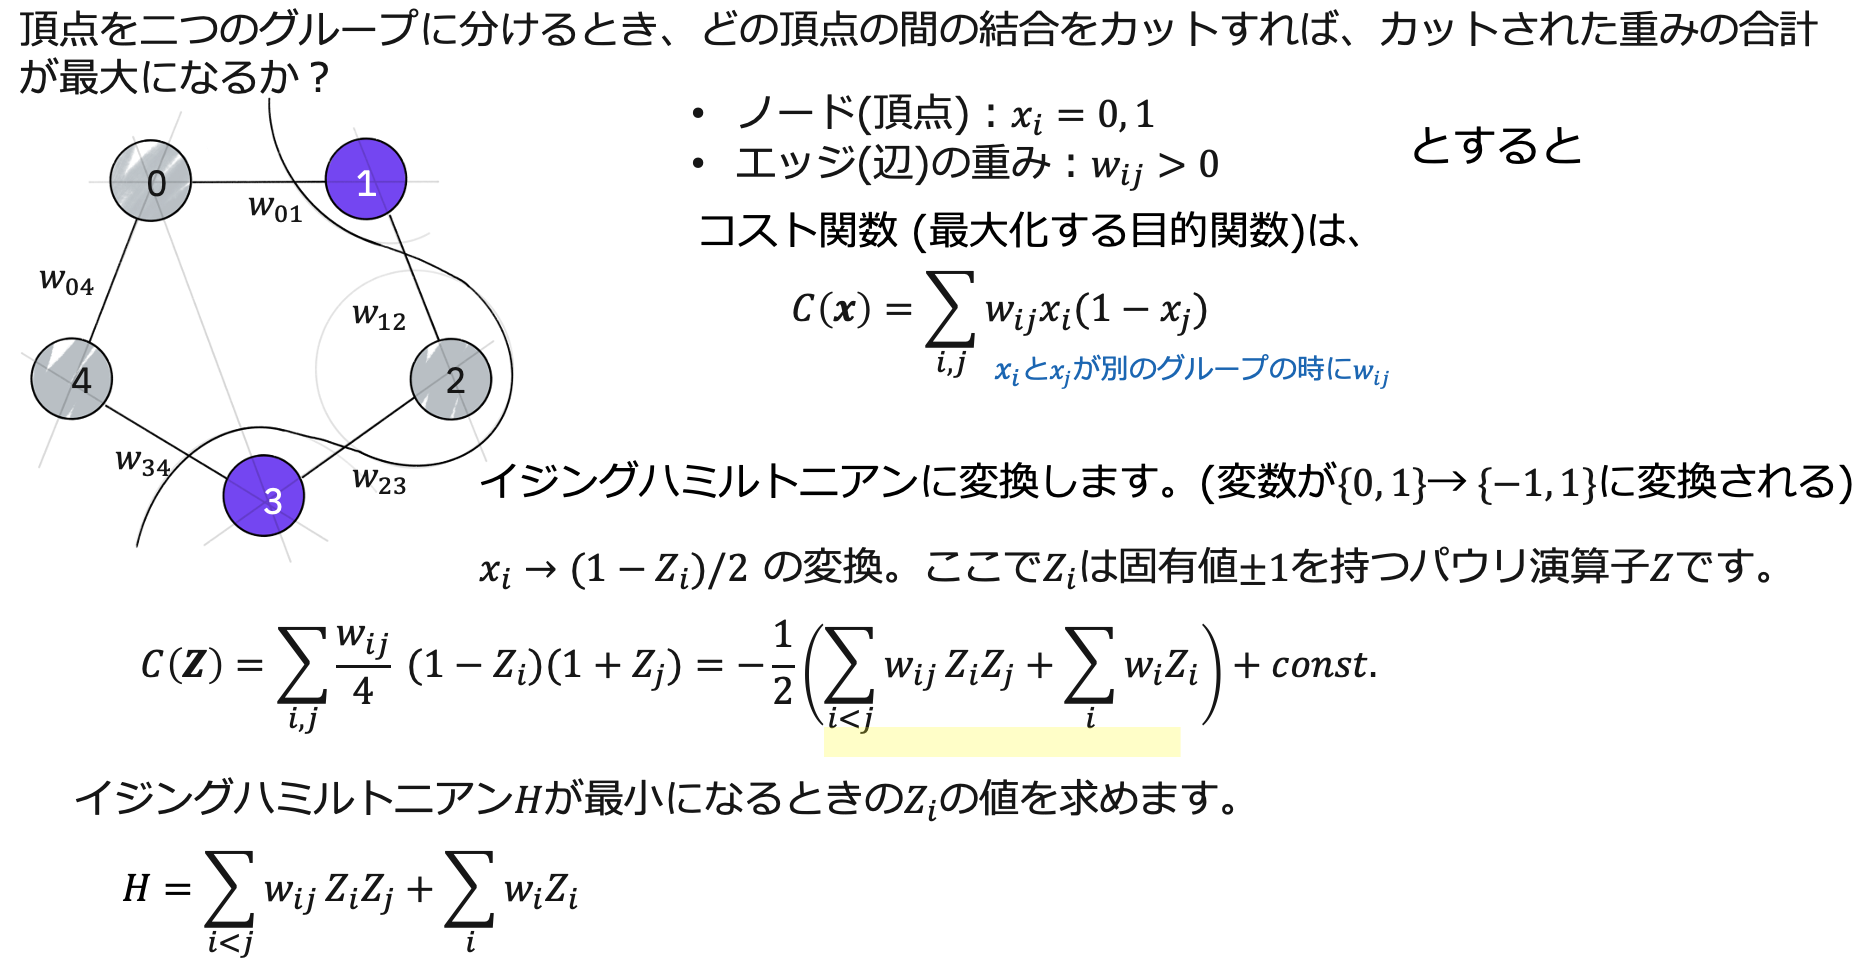

最大カット問題をQiskitのOptimization アプリケーション・クラスを使って実装します。まずは必要なライブラリーを導入します。

In [15]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx # グラフ/ネットワーク理論系の計算用パッケージ

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms.minimum_eigensolvers import VQE, SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.primitives import Sampler

4ノードのグラフを生成します。

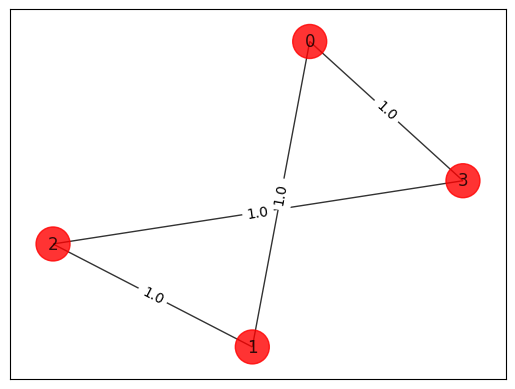

In [8]:
n = 4  # グラフのノード数
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1)) #arangeで間隔を指定した等差数列を生成して、ノードをグラフに追加
elist = [(0, 1, 1.0), (0, 3, 1.0), (2, 3, 1.0), (1, 2, 1.0)]
# 上記タプルは(i,j,weight)で(i,j)がエッジです
G.add_weighted_edges_from(elist) #グラフに重みを追加

# グラフの描画
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [9]:
# グラフGの重み行列wを計算 (後でMaxcutアプリケーションで使う)
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

print(elist)
print(w)

[(0, 1, 1.0), (0, 3, 1.0), (2, 3, 1.0), (1, 2, 1.0)]
[[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


Qiskit Optimizationライブラリーの`Maxcut`アプリケーション・クラスを使って、重み行列`w`から問題を設定し、`to_quadratic_program()`を使って、二次計画問題`QuadraticProgram`を生成します。

In [10]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 2*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



上記は、
$\tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)$
に重み行列`w`を入れたもので、
$\tilde{C}(\textbf{x})=-2x_0x_1 -2x_0x_3 -2x_1x_2 -2x_2x_3 +2x_0 + 2x_1 + 2x_2 + 2x_3$
です。この最大値が今回の最大カット問題の解です。

この二次計画形式の問題`qp`を$x_i\rightarrow (1-Z_i)/2$を使って、イジング・ハミルトニアン形式に変換します。

In [11]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.0
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


$H = \frac{1}{2}(Z_0Z_1+Z_0Z_2+Z_0Z_3+Z_2Z_3)-2.0$　に変換されました(この時、Qiskitの表示では右からindexがついていることに気をつけてください)。この最小値を求めます。

この問題は小さいので、古典の最小固有値ソルバーを使って二次計画問題`qp`の厳密解を求めることができる(行列計算の固有値計算で求める)ため、参考値として求めておきます。

In [12]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


$\tilde{C}(\textbf{x})=-2x_0x_1 -2x_0x_3 -2x_1x_2 -2x_2x_3 +2x_0 + 2x_1 + 2x_2 + 2x_3$に上記の解を入れると、4になっているはずです。

ハミルトニアン形式の問題からも以下のように厳密解を求めることができます。二次形式問題では最大問題でしたが、ハミルトニアン形式では最小値問題に変換され、$H = \frac{1}{2}(Z_0Z_1+Z_0Z_2+Z_0Z_3+Z_2Z_3)-2.0$ の最小値は$-4$と求められています。

energy: -2.0
max-cut objective: -4.0
solution: [1. 0. 1. 0.]
solution objective: 4.0


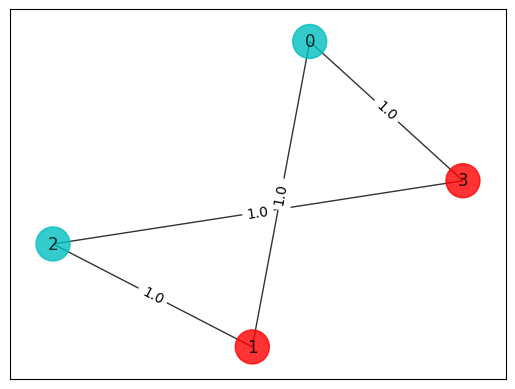

In [13]:
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

赤色のグループと緑色のグループに分割するときに、カットされるエッジの重みの和が最大になります。

この問題をVQEを使って、量子コンピューター(シミュレーター)で実行します。

In [16]:
# 実行環境の設定
algorithm_globals.random_seed = 123
seed = 10598
#backend = Aer.get_backend("aer_simulator_statevector")
#quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed) 

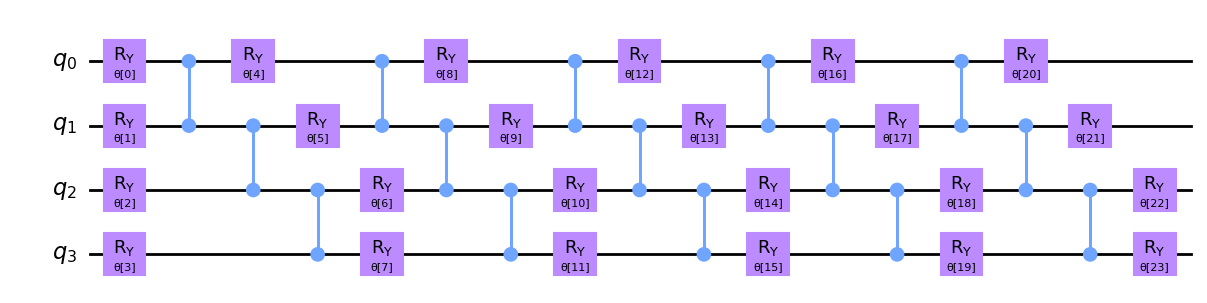

In [17]:
# VQEのための設定
spsa = SPSA(maxiter=300) #古典オプティマイザー
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear") #Ansatz

# Ansatzを表示してみます
ry.decompose().draw("mpl")

energy: -1.9995900934685775
time: 4.395707845687866
max-cut objective: -3.9995900934685773
solution: [0 1 0 1]
solution objective: 4.0


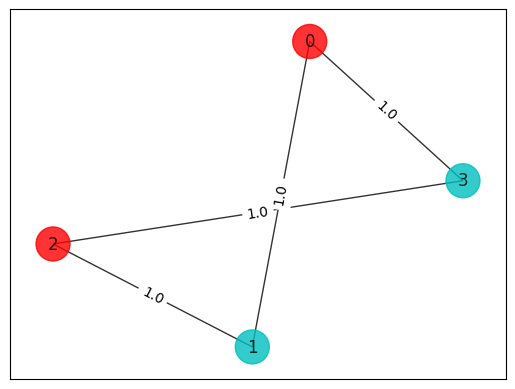

In [18]:
# VQEの実行
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=spsa)
result = vqe.compute_minimum_eigenvalue(qubitOp)

# 結果の表示
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

グラフが厳密解と同じグループに分割され、最大カット問題の目的関数もほぼ同じ値を求めることができました。

## ノイズのあるシミュレーションでの実行
フェイクデバイスを使って実行してみましょう。

In [23]:
# Use noise model
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeBelem

backend = FakeBelem()  # 5 qubits
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
print(coupling_map)
print(noise_model)

[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'id', 'sx', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [26]:
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler

algorithm_globals.random_seed = seed
sampler = BackendSampler(backend=AerSimulator.from_backend(FakeBelem()), options={"shots": 1000})

vqe = SamplingVQE(sampler=sampler, ansatz=ry, optimizer=spsa)
result = vqe.compute_minimum_eigenvalue(qubitOp)

energy: -1.3860000000000001
time: 43.550220012664795
max-cut objective: -3.386
solution: [1 0 1 0]
solution objective: 4.0


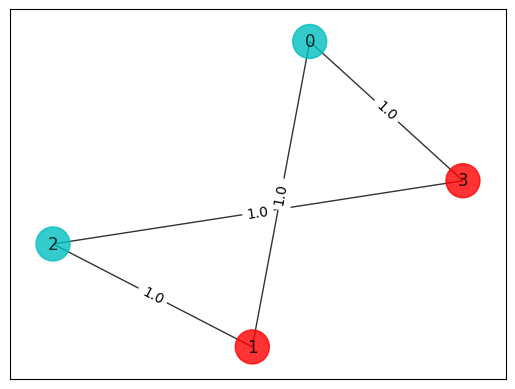

In [27]:
# 結果の表示
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

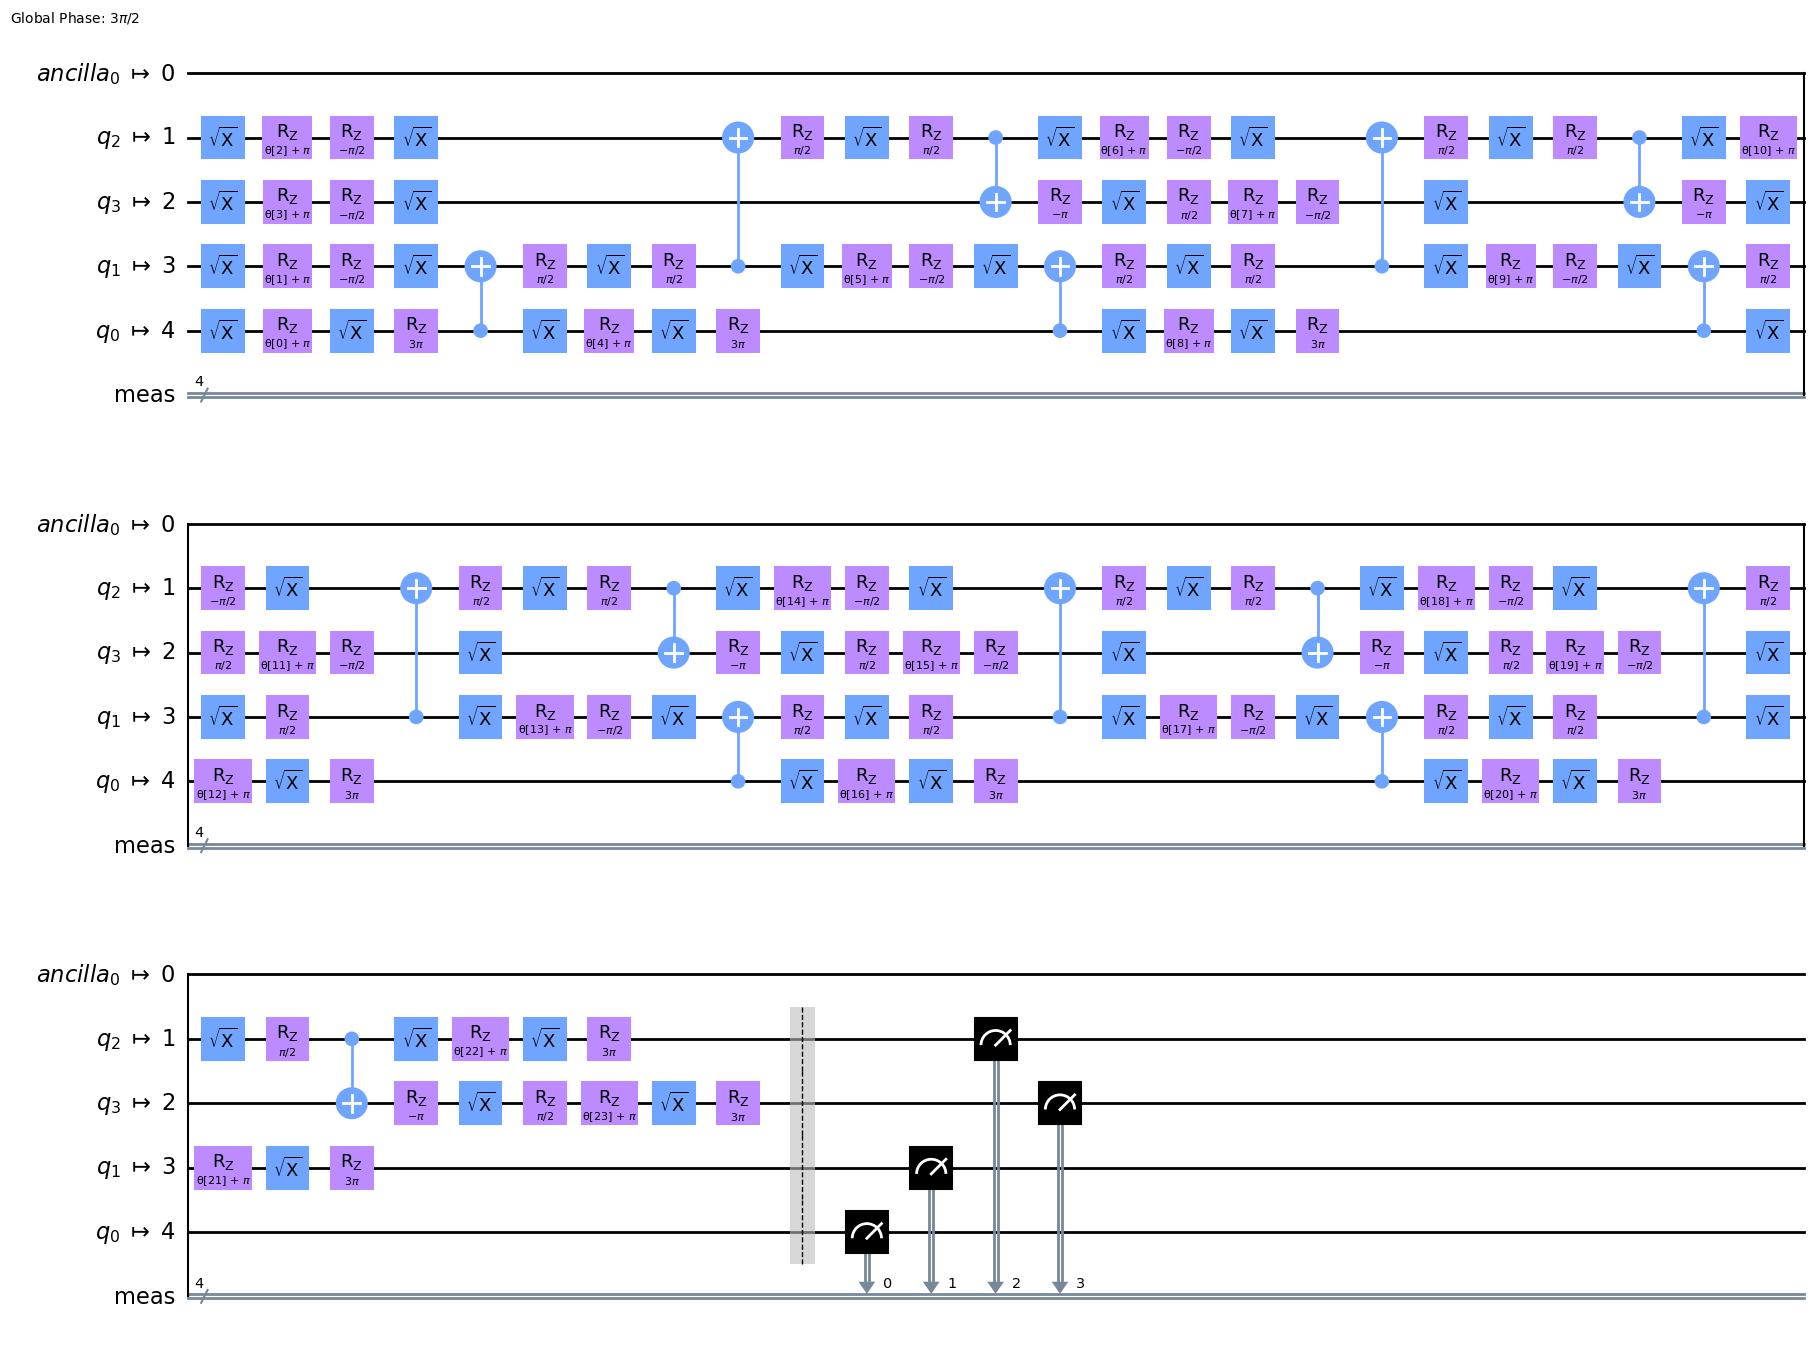

In [28]:
sampler.transpiled_circuits[0].draw(output="mpl")

In [30]:
# Qiskitバージョンの確認
import qiskit.tools.jupyter
%qiskit_version_table